<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Train-models-after-great-redesign" data-toc-modified-id="Train-models-after-great-redesign-1">Train models after great redesign</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-1.3">Code</a></span><ul class="toc-item"><li><span><a href="#Data-generation" data-toc-modified-id="Data-generation-1.3.1">Data generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.3.2">Evaluation</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1.3.3">Visualization</a></span></li></ul></li><li><span><a href="#Agent-evaluation" data-toc-modified-id="Agent-evaluation-1.4">Agent evaluation</a></span><ul class="toc-item"><li><span><a href="#Bug-fix-agent-change" data-toc-modified-id="Bug-fix-agent-change-1.4.1">Bug fix agent change</a></span></li><li><span><a href="#Reevaluate-frozen-agents" data-toc-modified-id="Reevaluate-frozen-agents-1.4.2">Reevaluate frozen agents</a></span></li><li><span><a href="#New-agents" data-toc-modified-id="New-agents-1.4.3">New agents</a></span></li></ul></li><li><span><a href="#Visualizing-agent-play" data-toc-modified-id="Visualizing-agent-play-1.5">Visualizing agent play</a></span><ul class="toc-item"><li><span><a href="#40_study_effect_of_epsilon/04_epsilon_greedy_001" data-toc-modified-id="40_study_effect_of_epsilon/04_epsilon_greedy_001-1.5.1">40_study_effect_of_epsilon/04_epsilon_greedy_001</a></span></li></ul></li><li><span><a href="#Study-train-data-to-create-new-metrics" data-toc-modified-id="Study-train-data-to-create-new-metrics-1.6">Study train data to create new metrics</a></span><ul class="toc-item"><li><span><a href="#Code" data-toc-modified-id="Code-1.6.1">Code</a></span></li><li><span><a href="#First-explorations" data-toc-modified-id="First-explorations-1.6.2">First explorations</a></span></li><li><span><a href="#Match-visualization" data-toc-modified-id="Match-visualization-1.6.3">Match visualization</a></span></li></ul></li><li><span><a href="#Study-game-data-after-improving-certain-death-reward" data-toc-modified-id="Study-game-data-after-improving-certain-death-reward-1.7">Study game data after improving certain death reward</a></span></li><li><span><a href="#Update-reward-on-train-data" data-toc-modified-id="Update-reward-on-train-data-1.8">Update reward on train data</a></span></li><li><span><a href="#Direct-reward-propagation-when-death-in-all-movements" data-toc-modified-id="Direct-reward-propagation-when-death-in-all-movements-1.9">Direct reward propagation when death in all movements</a></span><ul class="toc-item"><li><span><a href="#Study-reward-values" data-toc-modified-id="Study-reward-values-1.9.1">Study reward values</a></span></li><li><span><a href="#Improve-rewards" data-toc-modified-id="Improve-rewards-1.9.2">Improve rewards</a></span></li><li><span><a href="#Visualize-model-predictions" data-toc-modified-id="Visualize-model-predictions-1.9.3">Visualize model predictions</a></span><ul class="toc-item"><li><span><a href="#Old-model" data-toc-modified-id="Old-model-1.9.3.1">Old model</a></span></li><li><span><a href="#New-model" data-toc-modified-id="New-model-1.9.3.2">New model</a></span></li></ul></li><li><span><a href="#Modify-the-train-data" data-toc-modified-id="Modify-the-train-data-1.9.4">Modify the train data</a></span></li></ul></li><li><span><a href="#Useful-snippets" data-toc-modified-id="Useful-snippets-1.10">Useful snippets</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.11">Summary</a></span></li></ul></li></ul></div>

# Train models after great redesign

## Goal

The goal of this notebooks is to hopefully do the last steps with Q* learning

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm
import time
from itertools import permutations
from functools import partial
import gc
from concurrent.futures import ProcessPoolExecutor
import json
import logging
import glob
from IPython.display import clear_output
import tempfile
import yaml
import seaborn as sns

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import tensorflow.keras as keras

from hungry_geese import GameState
from hungry_geese.state import make_board_egocentric, get_head_position, combine_data, horizontal_simmetry, vertical_simmetry
from hungry_geese.utils import ACTIONS, opposite_action, get_timestamp, log_ram_usage, configure_logging
from hungry_geese.definitions import ACTION_TO_IDX
from hungry_geese.agents import EpsilonAgent, QValueAgent, SoftmaxAgent, QValueSafeAgent, QValueSemiSafeAgent
from hungry_geese.evaluation import play_matches_in_parallel, monitor_progress
from hungry_geese.elo import EloRanking
from hungry_geese.model import simple_model, create_model_for_training

%config Completer.use_jedi = False

Loading environment football failed: No module named 'gfootball'


In [3]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

configure_logging(logging.INFO)
logger = logging.getLogger(__name__)

## Code

### Data generation

In [4]:
def play_matches_in_parallel_and_save_history(agents, max_workers=20, n_matches=1000,
                                              output_path=None,
                                              running_on_notebook=True):
    """
    Plays n_matches in parallel using ProcessPoolExecutor

    Parameters
    -----------
    agents : list
        List of the agents that we will use for playing
    """
    log_ram_usage()
    output_path = output_path or get_games_output_path(agents, n_matches)
    assert not os.path.exists(output_path), 'Output path already exists: %s' % output_path
    with ProcessPoolExecutor(max_workers=max_workers) as pool:
        matches_results = []
        submits = []
        for i in range(n_matches):
            if isinstance(agents, list):
                submits.append(pool.submit(play_game, agents=agents))
            elif callable(agents):
                submits.append(pool.submit(play_game, agents=agents()))
            else:
                raise TypeError(type(agents))
        monitor_progress(submits, running_on_notebook)
        matches_results = [submit.result() for submit in submits]
    
    log_ram_usage()
    logger.info('saving matches to json: %s' % output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump(matches_results, f)
        
    del submits
    del matches_results
    gc.collect()
    log_ram_usage()

def play_game(agents):
    env = make("hungry_geese")
    return env.run(agents=agents)

def get_games_output_path(agents, n_matches):
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agents[0]))[0], 
        os.path.splitext(os.path.basename(agents[1]))[0], 
        n_matches)
    return output_path

In [5]:
def test_agent(agent):
    print('Testing agent: %s' % agent)
    env = make('hungry_geese', debug=True)
    env.run([agent]*4)

In [6]:
def create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=None):
    """
    Creates train data without any simmetry
    
    Parameters
    ----------
    saved_games_paths : list of str
        Path to the games that we want to use
    reward_name : str
        Name of the reward function that we want to use
    output_path : str
        Path to the file were we are going to save the results
    max_workers : int
    agent_idx_range : list of int
        Idx of the agents we want to use for collecting data, if None all the agents
        will be used
    """
    env = make("hungry_geese")
    conf = env.configuration

    state = GameState(reward_name=reward_name)
    train_data = []
    agent_idx_range = agent_idx_range or list(range(4))
    
    for saved_games_path in tqdm(saved_games_paths, desc='looping over saved games'):
        log_ram_usage()
        with open(saved_games_path, 'r') as f:
            matches_results = json.load(f)
        log_ram_usage()
    
        for _ in tqdm(range(len(matches_results)), desc='Creating game data'):
            match = matches_results[0]
            for idx in agent_idx_range:
                state.reset()
                for step_idx, step in enumerate(match):
                    observation = step[0]['observation'].copy()
                    observation['index'] = idx
                    state.update(observation, conf)
                    if step_idx:
                        state.add_action(step[idx]['action'])
                    if not observation['geese'][idx]:
                        break
                train_data.append(state.prepare_data_for_training())
            del matches_results[0]
        
    log_ram_usage()
    logger.info('Going to combine the data')
    train_data = combine_data(train_data)
    log_ram_usage()
    logger.info('Size of the boards is %.1f GB (%s [%.1f GB])' % (
        train_data[0].nbytes/1e9,
        str([round(data.nbytes/1e9, 1) for data in train_data]),
        np.sum([data.nbytes/1e9 for data in train_data])))
    logger.info('Saving data on: %s' % output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.savez_compressed(output_path, boards=train_data[0], features=train_data[1], actions=train_data[2], rewards=train_data[3])
    del state
    del train_data
    gc.collect()
    log_ram_usage()

In [7]:
def create_train_data(agents, n_matches, reward_name, agent_idx_range=None):
    """
    Creates train data without any simmetry
    
    Parameters
    ----------
    agents : list of str
        Names or paths of the agents
    n_matches : int
        Number of matches to play
    reward_name : str
        Name of the reward function that we want to use
    max_workers : int
    agent_idx_range : list of int
        Idx of the agents we want to use for collecting data, if None all the agents
        will be used
    """
    saved_games_path = get_games_output_path(agents, n_matches)
    if not os.path.exists(saved_games_path):
        play_matches_in_parallel_and_save_history(agents, n_matches=n_matches)

    output_path = get_data_output_path(agents, n_matches, reward_name)
    create_train_data_from_saved_matches([saved_games_path], reward_name, output_path, agent_idx_range=agent_idx_range)
    
def get_data_output_path(agents, n_matches, reward_name):
    output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
        reward_name,
        os.path.splitext(os.path.basename(agents[0]))[0], 
        os.path.splitext(os.path.basename(agents[1]))[0], 
        n_matches)
    return output_file

### Evaluation

In [8]:
initial_elo_ranking = pd.read_csv('../data/elo_ranking.csv', index_col='model')
initial_elo_ranking

,ranking
model,
obelix,1646
gargantua,1627
rhaegar,1612
balerion,1565
icedragon,1562
iceberg,1490
wallbreaker,1460
ram,1450
clasic,1314


In [9]:
with open('../data/agents.yml', 'r') as f:
    agents = yaml.safe_load(f)

In [10]:
def evaluate_agent(new_agent, adversary_agents, n_matches, single_agent=True, max_workers=20, run_agent_test=False):
    agent_name = list(new_agent.keys())[0]
    # I have found that for certain agents if the test is run then evaluation is frozen
    if run_agent_test: test_agent(new_agent[agent_name])
    reduced_agents_set = new_agent.copy()
    for adversary_agent in adversary_agents:
        reduced_agents_set[adversary_agent] = agents[adversary_agent]
    
    if single_agent:
        sample_agents_func = lambda: [agent_name] + np.random.choice(adversary_agents, 3, replace=False).tolist()
    else:
        def sample_agents_func():
            while 1:
                sampled_agents = [agent_name] + np.random.choice(adversary_agents + [agent_name], 3).tolist()
                if len(np.unique(sampled_agents)) >=2:
                    break
            return sampled_agents

    matches_agents, matches_results = play_matches_in_parallel(reduced_agents_set, sample_agents_func, n_matches=n_matches, max_workers=max_workers)
    return matches_agents, matches_results, reduced_agents_set
    
def compute_elo_ranking(matches_agents, matches_results, reduced_agents_set):
    initial_agent_elo = 1000
    for k in [32, 16, 8, 4, 2, 1]:
        agent_name = [name for name in reduced_agents_set if name not in initial_elo_ranking][0]
        initial_ranking = initial_elo_ranking.to_dict()['ranking']
        initial_ranking[agent_name] = initial_agent_elo
        initial_ranking = {key: initial_ranking[key] for key in reduced_agents_set}
        elo_ranking = EloRanking(initial_ranking, {agent_name}, k=k)
        for match_agents, match_results in zip(matches_agents, matches_results):
            elo_ranking.add_match(match_agents, match_results)
        initial_agent_elo = elo_ranking.summary().loc[agent_name, 'ranking']
    elo_ranking.plot()
    return elo_ranking.summary()

In [11]:
def simple_agent_evaluation(agent_path, n_matches=500):
    """
    Computes single and multi agents scores and returns them
    
    Parameters
    ----------
    multi_agent_elo_score
    single_agent_elo_score
    """
    ret = evaluate_agent(
        {'q_value_pretrained': agent_path},
        initial_elo_ranking.index.values.tolist()[:5],
        n_matches=n_matches, single_agent=False, max_workers=20)
    table_multi = compute_elo_ranking(*ret)
    ret = evaluate_agent(
        {'q_value_pretrained': agent_path},
        initial_elo_ranking.index.values.tolist()[:5],
        n_matches=n_matches, single_agent=True, max_workers=20)
    table_single = compute_elo_ranking(*ret)
    plt.close('all')
    clear_output()
    print(agent_path)
    print('Multi agent elo score: %i' % table_multi.loc['q_value_pretrained', 'ranking'])
    print('Single agent elo score: %i' % table_single.loc['q_value_pretrained', 'ranking'])
    return table_multi.loc['q_value_pretrained', 'ranking'], table_single.loc['q_value_pretrained', 'ranking']

In [12]:
def simple_model_evaluation(model_path, n_matches=500):
    model_path = os.path.realpath(model_path)
    text = """
import os
from hungry_geese.agents import QValueSemiSafeAgent
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
model = tf.keras.models.load_model('model_path', compile=False)
q_value_agent = QValueSemiSafeAgent(model)
def agent(obs, config):
    return q_value_agent(obs, config)
    """
    text = text.replace('model_path', model_path)
    with tempfile.TemporaryDirectory() as tempdir:
        agent_filepath = os.path.join(tempdir, 'agent.py')
        with open(agent_filepath, 'w') as f:
            f.write(text)
        output = simple_agent_evaluation(agent_filepath, n_matches=n_matches)
    return output

### Visualization

In [13]:
def plot_q_value(agent):
    values = np.array(agent.q_values)
    for idx in range(values.shape[1]):
        plt.plot(values[:, idx], label=idx, alpha=0.6, marker='o')
    plt.legend(loc=0)
    plt.grid()

In [14]:
COLOR_TO_INDEX = dict(white=0, blue=1, green=2, red=3)

In [15]:
def save_html_game(agents, output_folder):
    """
    Plays a game, saves to file and opens it on google chrome
    
    
    Order of the agents
    
    - 0 white
    - 1 blue
    - 2 green
    - 3 red
    """
    os.makedirs(output_folder, exist_ok=True)
    env = make('hungry_geese')
    ret = env.run(agents);
    html_content = env.render(mode="html")
    filepath = os.path.join(output_folder, '%s.html' % get_timestamp())
    with open(filepath, 'w') as f:
        f.write(html_content)
    print(filepath)
    os.system('google-chrome "%s"' % os.path.realpath(filepath))

In [16]:
def save_html_games(agents, output_folder, n_games=10):
    os.makedirs(output_folder, exist_ok=True)
    env = make('hungry_geese')
    for game_idx in tqdm(range(n_games)):
        ret = env.run(agents);
        html_content = env.render(mode="html")
        filepath = os.path.join(output_folder, '%02d.html' % game_idx)
        with open(filepath, 'w') as f:
            f.write(html_content)

## Agent evaluation

### Bug fix agent change

In [ ]:
# with the bug
simple_model_evaluation('/mnt/hdd0/Kaggle/hungry_geese/models/38_great_redesign_debug/11_discount_factor_1_epsilon_greedy_01/epoch_5200.h5', n_matches=500)

In [ ]:
# after fixing the bug
simple_model_evaluation('/mnt/hdd0/Kaggle/hungry_geese/models/38_great_redesign_debug/11_discount_factor_1_epsilon_greedy_01/epoch_5200.h5', n_matches=500)

In [ ]:
# after fixing the bug and fixing the agents
simple_model_evaluation('/mnt/hdd0/Kaggle/hungry_geese/models/38_great_redesign_debug/11_discount_factor_1_epsilon_greedy_01/epoch_5200.h5', n_matches=500)

In [ ]:
# after fixing the bug and fixing the agents, and reevaluating the agents
simple_model_evaluation('/mnt/hdd0/Kaggle/hungry_geese/models/38_great_redesign_debug/11_discount_factor_1_epsilon_greedy_01/epoch_5200.h5', n_matches=500)

### Reevaluate frozen agents

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/data/agents/clasic.py')

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/data/agents/ram.py')

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/data/agents/wallbreaker.py')

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/data/agents/iceberg.py')

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/data/agents/icedragon.py')

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/data/agents/balerion.py')

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/data/agents/rhaegar.py')

In [ ]:
simple_agent_evaluation('')

### New agents

In [ ]:
simple_model_evaluation('/mnt/hdd0/Kaggle/hungry_geese/models/40_study_effect_of_epsilon/04_epsilon_greedy_001/epoch_7920.h5', n_matches=500)

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/gargantua.py', n_matches=500)

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/gargantua_data_augmentation.py', n_matches=500)

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/obelix.py', n_matches=500)

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/obelix_data_augmentation.py', n_matches=500)

Is strange that in this case data augmented agent gets a worse result.

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/arnold.py', n_matches=500)

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/arnold_data_augmentation.py', n_matches=500)

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/sylvester.py', n_matches=500)

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/sylvester_data_augmentation.py', n_matches=500)

I'm struggling to get as good scores as gargantua, even it it seems that this new models are better. I think reward may play a role because when the end of the match is achieved I'm not currently given different reward for a different position.

Let's try with an smaller model that uses 128 units instead of 256

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/jagger.py', n_matches=500)

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/jagger_data_augmentation.py', n_matches=500)

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/decurion.py', n_matches=500)

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/decurion_data_augmentation.py', n_matches=500)

In [20]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/centurion.py', n_matches=500)

/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/centurion.py
Multi agent elo score: 1735
Single agent elo score: 1733


(1735, 1733)

In [21]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/centurion_data_augmentation.py', n_matches=500)

/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/centurion_data_augmentation.py
Multi agent elo score: 1753
Single agent elo score: 1763


(1753, 1763)

In [17]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/tiberio.py', n_matches=500)

/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/tiberio.py
Multi agent elo score: 1767
Single agent elo score: 1775


(1767, 1775)

In [18]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/tiberio_data_augmentation.py', n_matches=500)

/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/scripts/q_value_submission/tiberio_data_augmentation.py
Multi agent elo score: 1791
Single agent elo score: 1829


(1791, 1829)

## Visualizing agent play

### 40_study_effect_of_epsilon/04_epsilon_greedy_001

In [ ]:
model = keras.models.load_model('/mnt/hdd0/Kaggle/hungry_geese/models/40_study_effect_of_epsilon/04_epsilon_greedy_001/epoch_7920.h5', compile=False)
agents = [QValueSemiSafeAgent(model) for idx in range(4)]

[agent.reset() for agent in agents]; save_html_game(agents, '../data/saved_games/06_semi_safe')

The level of playing is really good. I like seeing this matches.

In [ ]:
agents[COLOR_TO_INDEX['red']].q_values[-1]

In [ ]:
np.array(agents[COLOR_TO_INDEX['green']].q_values)[24]

In [ ]:
plot_q_value(agents[COLOR_TO_INDEX['green']])

Let's also play against the frozen agents.

In [ ]:
[agent.reset() for agent in agents]; save_html_game(agents[:1] + ['../data/agents/rhaegar.py', '../data/agents/balerion.py', '../data/agents/icedragon.py'], '../data/saved_games/06_semi_safe')

## Study train data to create new metrics

The initial goal was to create new metrics that will allow to better understand the behaviour of the agent. However I have found some evidences of problems with the data.

### Code

In [17]:
def match_duration_histogram(data):
    terminal_idx = get_terminal_indices(data)
    match_durations = get_match_durations(terminal_idx)
    plt.hist(match_durations, bins=np.linspace(0, 200, 20))
    plt.title('Histogram of match duration (%i matches)' % len(match_durations))
    plt.xlabel('steps')
    print('Mean match duration', np.mean(match_durations))
    
def get_terminal_indices(data):
    """ Returns the indices of the states that are terminal """
    terminal_idx = np.arange(len(data['is_not_terminal']))[np.sum(data['is_not_terminal'], axis=1) == 0]
    return terminal_idx

def get_match_durations(terminal_idx):
    match_durations = terminal_idx.copy()
    match_durations[1:] -= match_durations[:-1]
    return match_durations

In [18]:
def reward_vs_step_plot(data, jitter=0):
    terminal_idx = get_terminal_indices(data)
    match_durations = get_match_durations(terminal_idx)
    terminal_rewards = []
    for rewards, mask in zip(data['rewards'][terminal_idx], data['training_mask'][terminal_idx]):
        terminal_rewards.append(rewards[mask == 1])
    terminal_rewards = [max(rewards) for rewards in terminal_rewards]
    np.random.seed(8)
    plt.scatter(add_jitter(match_durations, jitter), terminal_rewards, alpha=0.6);
    plt.xlabel('step')
    plt.ylabel('reward')
    plt.grid(axis='y')
    
def add_jitter(x, jitter):
    x = np.array(x)
    return x + np.random.normal(0, jitter, x.shape)

In [19]:
def terminal_reward_histogram(data):
    terminal_rewards = get_terminal_reward(data)
    plt.hist(terminal_rewards)

def terminal_reward_dataframe(data):
    terminal_rewards = get_terminal_reward(data)
    values, counts = np.unique(terminal_rewards, return_counts=True)
    df = pd.DataFrame(dict(counts=counts), index=values)
    df.index.name = 'reward'
    return df

def get_terminal_reward(data):
    terminal_idx = get_terminal_indices(data)
    match_durations = get_match_durations(terminal_idx)
    terminal_rewards = []
    for rewards, mask in zip(data['rewards'][terminal_idx], data['training_mask'][terminal_idx]):
        terminal_rewards.append(rewards[mask == 1])
    terminal_rewards = [max(rewards) for rewards in terminal_rewards]
    return terminal_rewards

In [20]:
def explore_train_data(filepath):
    data = dict(**np.load(filepath))
    print(data.keys())
    match_duration_histogram(data); plt.show()
    reward_vs_step_plot(data, jitter=0.2); plt.show()
    return terminal_reward_dataframe(data)

In [21]:
def visualize_match(filepath, match_idx, model=None):
    """
    Plots a visualization of the match
    On the title shows the reward for that state
    If a model is given it shows the prediction for that state
    If a model is not give shows the training mask, and is_not_terminal 
    """
    data = dict(**np.load(filepath))
    _visualize_match(data, match_idx, model=model)
    
def _visualize_match(data, match_idx, model, n_cols=10, ):
    start, end = _get_match_start_and_end(data, match_idx)
    game_state = GameState()
    for plot_idx, step_idx in enumerate(range(start, end)):
        if not plot_idx % n_cols: plt.show()
        plt.subplot(1, n_cols, plot_idx%n_cols + 1)
        plt.imshow(game_state.render_board(data['boards'][step_idx]))
        plt.xticks([]); plt.yticks([])
        plt.title(data['rewards'][step_idx])
        plt.ylabel(plot_idx)
        if model is not None:
            action_value = _predict_action_value(model, data, step_idx)
            plt.xlabel(str(action_value.round(1)))
        else:
            plt.xlabel(str(data['training_mask'][step_idx]) + ' ' + str(data['is_not_terminal'][step_idx]))
        
def _get_match_start_and_end(data, match_idx):
    terminal_idx = get_terminal_indices(data)
    end = terminal_idx[match_idx] + 1
    if match_idx:
        start = terminal_idx[match_idx - 1] + 1
    else:
        start = 0
    return start, end

def _predict_action_value(model, data, step_idx):
    model_input = [data['boards'][step_idx:step_idx+1], data['features'][step_idx:step_idx+1]]
    return model.predict_step(model_input)[0].numpy()

### First explorations

In [ ]:
explore_train_data('/mnt/hdd0/Kaggle/hungry_geese/models/39_more_trains_after_bugfix/02_epsilon_greedy_01_discount_factor_1/epoch_1182.npz')

In [ ]:
explore_train_data('/mnt/hdd0/Kaggle/hungry_geese/models/39_more_trains_after_bugfix/02_epsilon_greedy_01_discount_factor_1/epoch_5200.npz')

Most of the rewards still -5 after 4000 epochs, how that can be?

- Visualize games: state, q_value and target
- target vs q_value

### Match visualization

In [ ]:
model = keras.models.load_model('/mnt/hdd0/Kaggle/hungry_geese/models/39_more_trains_after_bugfix/02_epsilon_greedy_01_discount_factor_1/epoch_1181.h5', compile=False)

In [ ]:
model = keras.models.load_model('/mnt/hdd0/Kaggle/hungry_geese/models/39_more_trains_after_bugfix/02_epsilon_greedy_01_discount_factor_1/epoch_5199.h5', compile=False)

In [ ]:
visualize_match('/mnt/hdd0/Kaggle/hungry_geese/models/39_more_trains_after_bugfix/02_epsilon_greedy_01_discount_factor_1/epoch_5200.npz', 2, model)

In [ ]:
visualize_match('/mnt/hdd0/Kaggle/hungry_geese/models/39_more_trains_after_bugfix/02_epsilon_greedy_01_discount_factor_1/epoch_1182.npz', 3, model)

In [ ]:
model = keras.models.load_model('/mnt/hdd0/Kaggle/hungry_geese/models/39_more_trains_after_bugfix/02_epsilon_greedy_01_discount_factor_1/epoch_1181.h5', compile=False)

I have the feeling that many of the deaths are caused by the epsilon greedy policy, I'm going to decrease epsilon and compare.

## Study game data after improving certain death reward

In [ ]:
visualize_match('/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on/01_first_steps/debug2.npz', 1, model=None)

In [ ]:
explore_train_data('/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on/01_first_steps/debug2.npz')

## Update reward on train data

In [22]:
def update_terminal_reward(reward):
    updated_reward = reward/5 -5
    updated_reward[reward > 0] = 5
    return updated_reward

In [23]:
def update_train_files(input_dir, output_dir):
    filepaths = sorted(glob.glob(os.path.join(input_dir, '*.npz')))
    os.makedirs(output_dir, exist_ok=True)
    
    with ProcessPoolExecutor(max_workers=20) as pool:
        submits = []
        for filepath in tqdm(filepaths, desc='creating jobs'):
            output_filepath = filepath.replace(input_dir, output_dir)
            submits.append(pool.submit(update_train_file, filepath, output_filepath))
        monitor_progress(submits, True)

        
def update_train_file(input_filepath, output_filepath):
    if os.path.exists(output_filepath):
        return
    data = dict(**np.load(input_filepath))
    data['rewards'][data['is_not_terminal'] == 0] = update_terminal_reward(data['rewards'][data['is_not_terminal'] == 0])
    np.savez_compressed(output_filepath, **data)

In [31]:
update_train_files(
    input_dir='/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on_terminal_kill_and_grow_reward/07_just_train_and_evaluate', 
    output_dir='/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on_terminal_kill_and_grow_reward/09_just_train_and_evaluate_reward_v2')

creating jobs:   0%|          | 0/4468 [00:00<?, ?it/s]

  0%|          | 0/4468 [00:00<?, ?it/s]

In [33]:
filepath = '/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on_terminal_kill_and_grow_reward/09_just_train_and_evaluate_reward_v2/epoch_03626_timestamp_2021_06_08_06_42_00.npz'
data = dict(**np.load(filepath))
np.unique(data['rewards'][data['is_not_terminal'] == 0], return_counts=True)

(array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,   5.]),
 array([5399,   71, 2726,   48, 1976,  114,   40]))

## Direct reward propagation when death in all movements

### Study reward values

Let's study the option of directly propagating death reward if all future movements lead to death.

In [34]:
filepath = '/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on_terminal_kill_and_grow_reward/09_just_train_and_evaluate_reward_v2/epoch_03626_timestamp_2021_06_08_06_42_00.npz'
data = dict(**np.load(filepath))
list(data.keys())

['boards', 'features', 'rewards', 'is_not_terminal', 'training_mask']

I have to find those situations where all actions are terminal, and training mask is on.

In [46]:
indices = np.arange(len(data['rewards']))[((1 - np.max(data['is_not_terminal'], axis=1))*np.min(data['training_mask'], axis=1)) == 1]
indices

array([  119,   206,   558,   641,  1236,  1665,  2534,  2652,  2851,
        3278,  3996,  4193,  5188,  6167,  6366,  6530,  7208,  7276,
        7376,  7574,  7728,  8467,  9263,  9811, 10638, 10957, 11897,
       12016, 12550, 12865, 14691, 14890, 15681])

In [57]:
len(indices)

33

We are lucky because the first case that we have found shows that we could propagate the death information 4 steps backwards. I have the intuition that the model won't be able to do that. We will try it once it is trained. This may have a big effect on learning to avoid death. Moreover it is happening 33% of the times, so this could be very relevant.

In [24]:
def visualize_rewards(idx, data):
    plt.figure(figsize=(30, 2.5))
    for plot_idx, key in enumerate(['rewards', 'is_not_terminal', 'training_mask']):
        plt.subplot(1, 3, plot_idx + 1)
        sns.heatmap(data[key][idx -5: idx + 1], annot=True, cbar=False)
        plt.title(key)

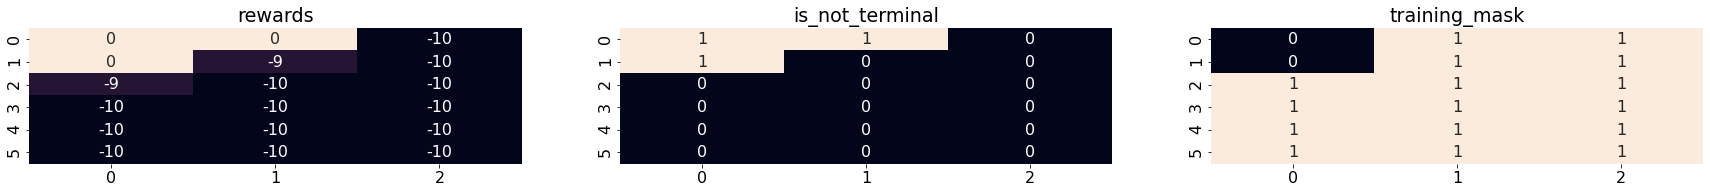

In [90]:
visualize_rewards(indices[0], data)

Same with the second one.

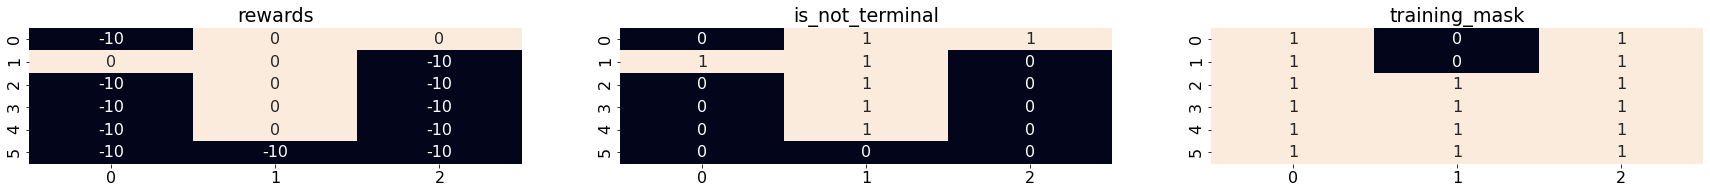

In [91]:
visualize_rewards(indices[1], data)

### Improve rewards

In [25]:
def find_indices_of_all_terminal_and_learnable_actions(data):
    indices = np.arange(len(data['rewards']))[((1 - np.max(data['is_not_terminal'], axis=1))*np.min(data['training_mask'], axis=1)) == 1]
    return indices

In [26]:
def propagate_death_reward_backwards(step, data, verbose=False):
    """
    Propagates death information from step to step -1, and
    continues to step -2 and so on if necessary
    """
    if verbose: print('Propagating death reward from step %i' % step)
    action_idx = np.arange(3)[(data['is_not_terminal'][step - 1]*data['training_mask'][step - 1]) == 1]
    if not action_idx.size: # I think this is very unlikely, but let's be cautious
        return
    data['is_not_terminal'][step - 1, action_idx] = 0
    data['rewards'][step - 1, action_idx] += np.max(data['rewards'][step])
    if np.max(data['is_not_terminal'][step - 1]) == 0 and np.min(data['training_mask'][step - 1]) == 1:
        propagate_death_reward_backwards(step - 1, data, verbose)

In [27]:
def show_after_and_before_death_reward_propagation(idx, data, verbose=False):
    visualize_rewards(idx, data); plt.show()
    propagate_death_reward_backwards(idx, data, verbose)
    visualize_rewards(idx, data)

If I find indices then I have to:

- Find which action of the previous state I have to modify
- Set the action to terminal
- Update the reward
- Check if I have to keep going backward or I should stop (recursive function)

In [110]:
data = dict(**np.load(filepath))

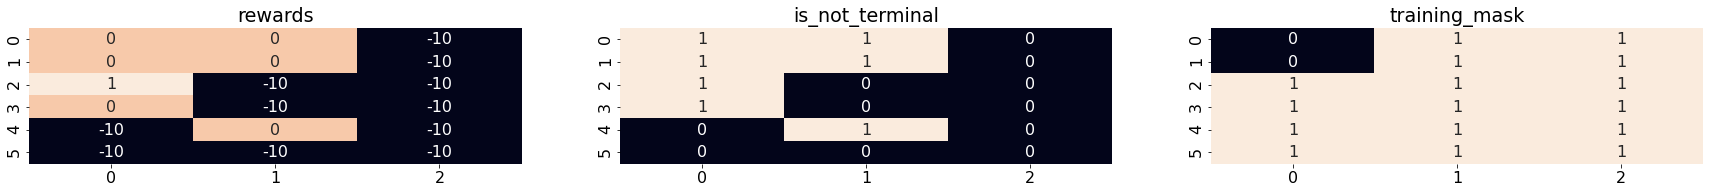

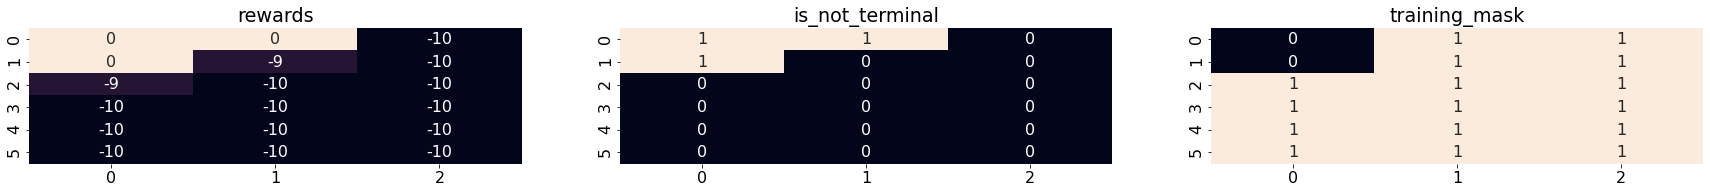

In [111]:
show_after_and_before_death_reward_propagation(indices[0], data, verbose=False)

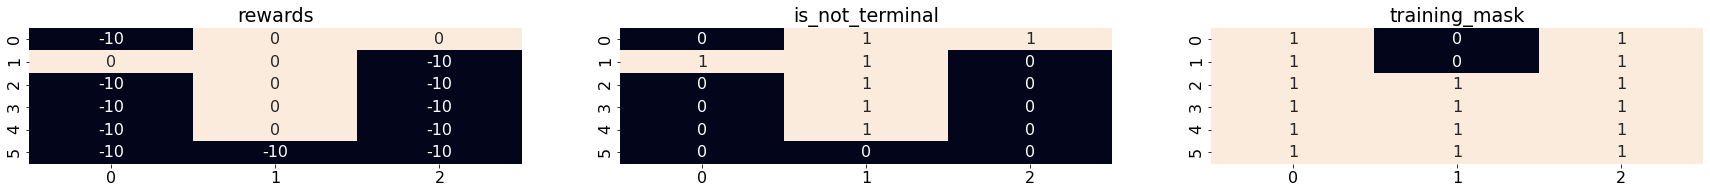

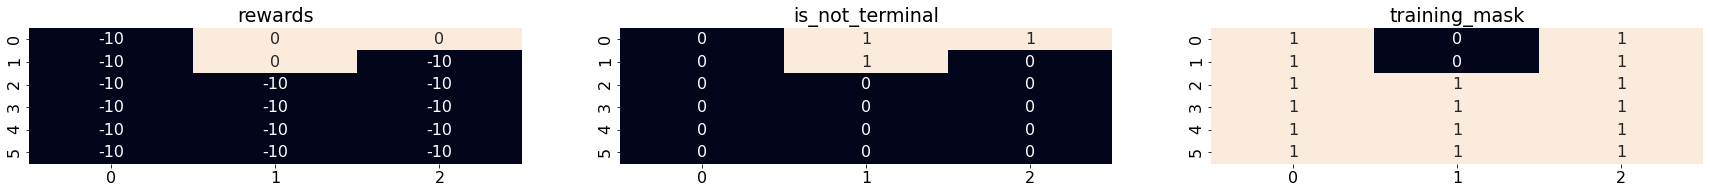

In [112]:
show_after_and_before_death_reward_propagation(indices[1], data, verbose=False)

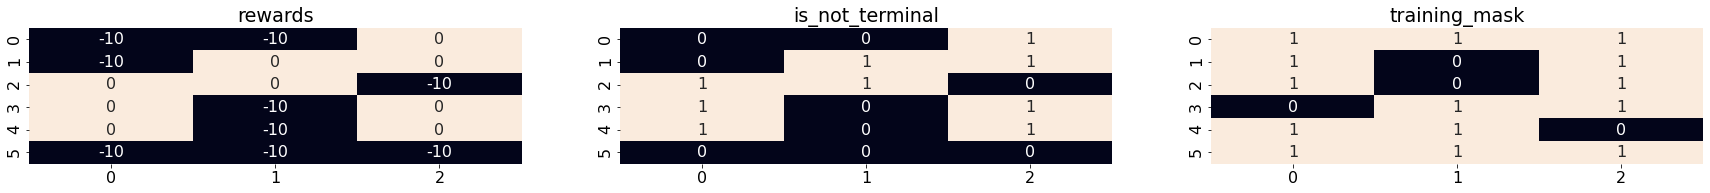

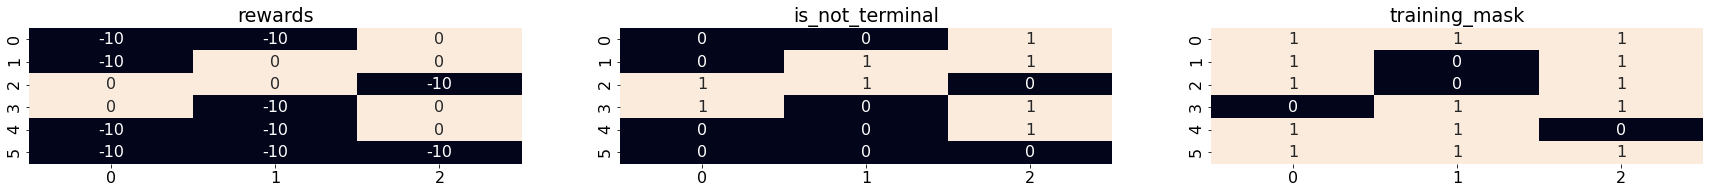

In [113]:
show_after_and_before_death_reward_propagation(indices[2], data)

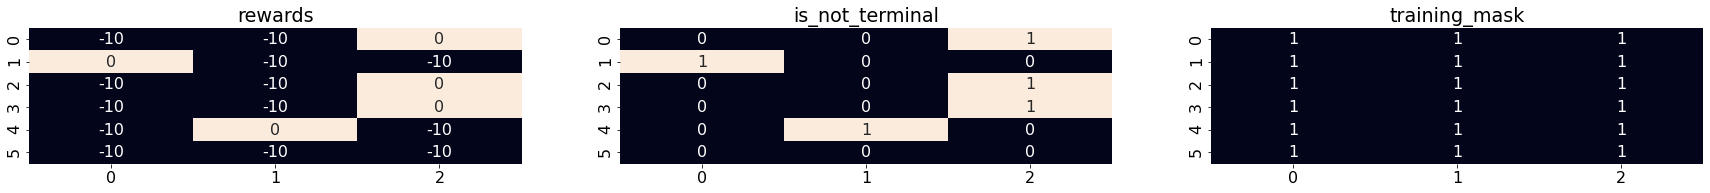

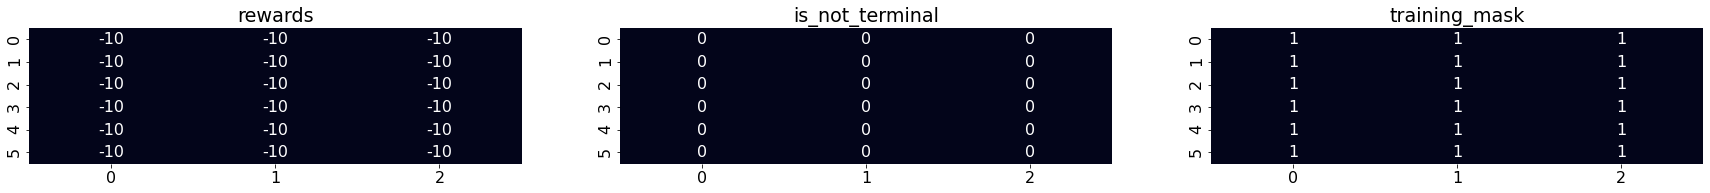

In [114]:
show_after_and_before_death_reward_propagation(indices[3], data)

### Visualize model predictions

#### Old model

In [123]:
model = keras.models.load_model('/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on_terminal_kill_and_grow_reward/09_just_train_and_evaluate_reward_v2/epoch_00160.h5', compile=True)

2021-06-08 17:51:24,284 - tensorflow - WARNING - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [28]:
def visualize_model_predictions(idx, data, model, n_steps=5):
    plt.figure(figsize=(30, 2.5))
    plt.subplot(1, 2, 1)
    sns.heatmap(data['rewards'][idx -n_steps: idx + 1], annot=True, cbar=False)
    plt.title('rewards')
    predictions = model.predict([data['boards'][idx -n_steps: idx + 1], data['features'][idx -n_steps: idx + 1]])
    plt.subplot(1, 2, 2)
    sns.heatmap(predictions, annot=True, cbar=False)
    plt.title('predictions')

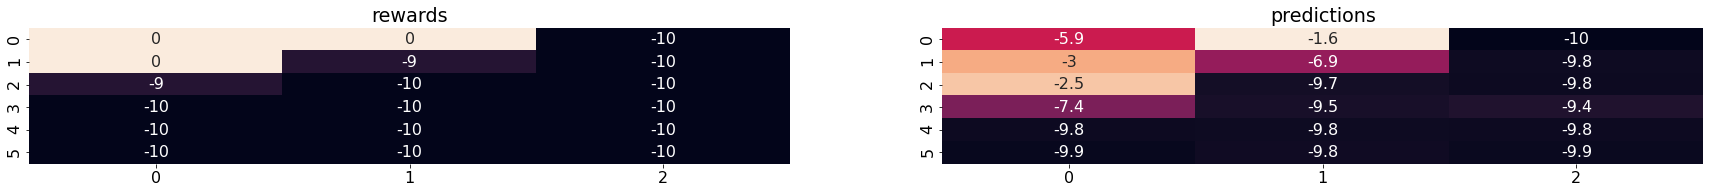

In [128]:
visualize_model_predictions(indices[0], data, model)

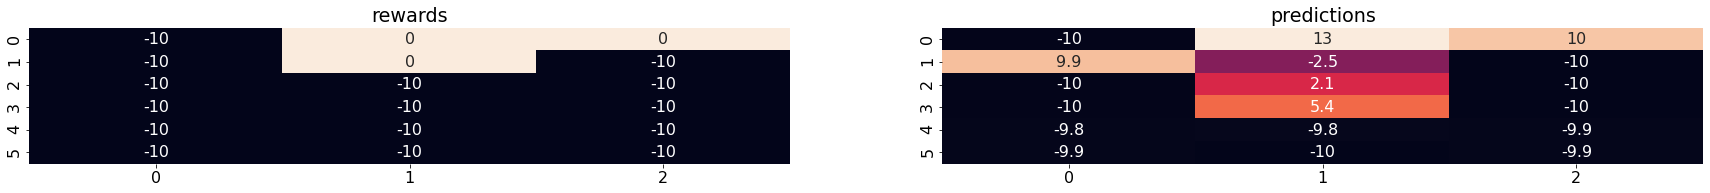

In [126]:
visualize_model_predictions(indices[1], data, model)

In this case it will still take the wrong decision.

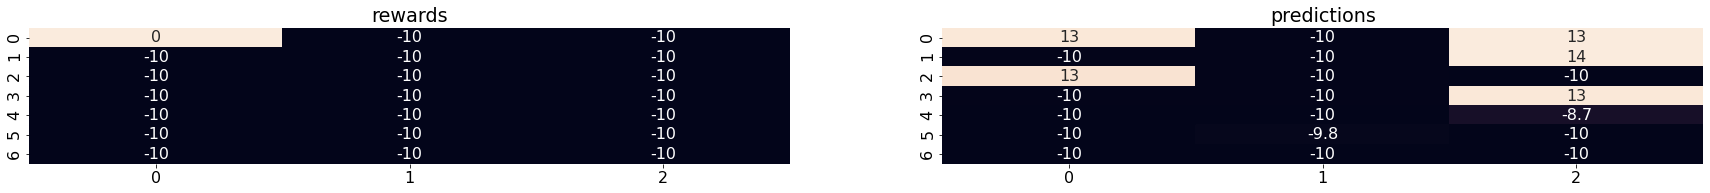

In [132]:
visualize_model_predictions(indices[3], data, model, n_steps=6)

We can see that some predictions are really wrong. So it is likely that by fixing the train data the model will learn better.

#### New model

In [29]:
model = keras.models.load_model('/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on_terminal_kill_and_grow_reward/11_just_train_and_evaluate_propagate_death_backwards_x512/epoch_00479.h5', compile=True)

2021-06-10 12:18:10,345 - tensorflow - WARNING - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [30]:
filepath = '/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on_terminal_kill_and_grow_reward/09_just_train_and_evaluate_reward_v2/epoch_03626_timestamp_2021_06_08_06_42_00.npz'
data = dict(**np.load(filepath))
indices = find_indices_of_all_terminal_and_learnable_actions(data)

In [31]:
new_data = dict(**np.load('/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on_terminal_kill_and_grow_reward/10_just_train_and_evaluate_propagate_death_backwards/epoch_03626_timestamp_2021_06_08_06_42_00.npz'))

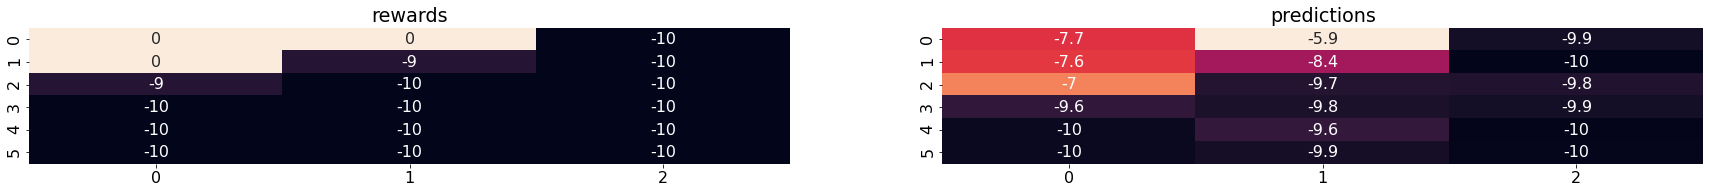

In [36]:
visualize_model_predictions(indices[0], new_data, model)

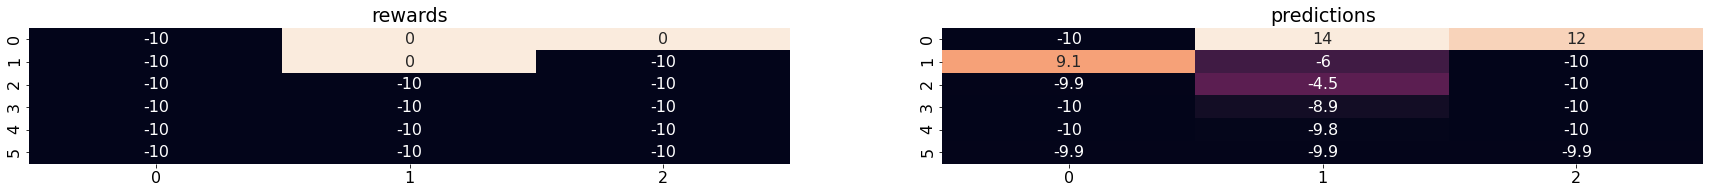

In [37]:
visualize_model_predictions(indices[1], new_data, model)

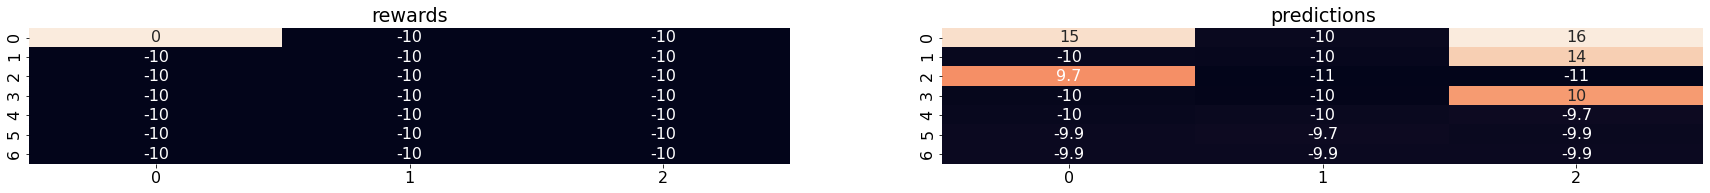

In [38]:
visualize_model_predictions(indices[3], new_data, model, n_steps=6)

We can see that it is not learning correctly always, but it is better.

### Modify the train data

In [35]:
def update_train_files_propagating_death_backwards(input_dir, output_dir):
    filepaths = sorted(glob.glob(os.path.join(input_dir, '*.npz')))
    os.makedirs(output_dir, exist_ok=True)
    
    with ProcessPoolExecutor(max_workers=20) as pool:
        submits = []
        for filepath in tqdm(filepaths, desc='creating jobs'):
            output_filepath = filepath.replace(input_dir, output_dir)
            submits.append(pool.submit(update_train_file_propagating_death_backwards, filepath, output_filepath))
        monitor_progress(submits, True)

        
def update_train_file_propagating_death_backwards(input_filepath, output_filepath):
    if os.path.exists(output_filepath):
        return
    data = dict(**np.load(input_filepath))
    indices = find_indices_of_all_terminal_and_learnable_actions(data)
    for idx in indices:
        propagate_death_reward_backwards(idx, data)
    np.savez_compressed(output_filepath, **data)

In [152]:
update_train_files_propagating_death_backwards(
    input_dir='/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on_terminal_kill_and_grow_reward/09_just_train_and_evaluate_reward_v2', 
    output_dir='/mnt/hdd0/Kaggle/hungry_geese/models/46_train_from_zero_on_terminal_kill_and_grow_reward/10_just_train_and_evaluate_propagate_death_backwards')

creating jobs:   0%|          | 0/4468 [00:00<?, ?it/s]

  0%|          | 0/4468 [00:00<?, ?it/s]

## Useful snippets

In [ ]:
simple_model_evaluation('/mnt/hdd0/Kaggle/hungry_geese/models/32_automated_iteration/13_continue_with_smaller_lr/epoch_0447.h5')

In [ ]:
simple_agent_evaluation('/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/data/agents/wallbreaker_data_augmentation.py', n_matches=500)

In [ ]:
model = keras.models.load_model('/mnt/hdd0/Kaggle/hungry_geese/models/32_automated_iteration/11_continue_with_scale_8/epoch_0347.h5', compile=False)
model = tf.keras.models.Model(inputs=model.inputs[:2], outputs=model.layers[-3].output)
agents = [QValueAgent(model) for idx in range(4)]

[agent.reset() for agent in agents]; save_html_game(agents, '../data/saved_games/03_clip_len_reward_analysis')
plot_q_value(agents[COLOR_TO_INDEX['white']]); plt.xlim(100)

In [ ]:
agent_base = '../data/agents/quantum/epsilon_quantum_010.py'
best_5_agents = [agents[name] for name in initial_elo_ranking.index.values[:4]]
best_5_agents += ['/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/04_epsilon010_vs_best5_reward_-4_4_x128_80000_pretrained/q_value_agent.py']
sampling_agent_func = lambda: [agent_base] + np.random.choice(best_5_agents, 3).tolist()

for n_matches in [8000, 39000, 40000]:
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches)
    play_matches_in_parallel_and_save_history(agents=sampling_agent_func, n_matches=n_matches, output_path=output_path)
    
reward_name = 'ranking_reward_-4_4'

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [8000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_it2_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 8000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

saved_games_paths = ['/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_best5_it2_matches_%i.json' % (os.path.splitext(os.path.basename(agent_base))[0], n_matches) for n_matches in [39000, 40000]]
output_path = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_best5_it2_matches_%i.npz' % (reward_name, os.path.splitext(os.path.basename(agent_base))[0], 80000)
create_train_data_from_saved_matches(saved_games_paths, reward_name, output_path, agent_idx_range=[0])

In [ ]:
agent_names = initial_elo_ranking.index.values.tolist()[:4]
output_folder = '../data/saved_games/02_quantum'
save_html_games([agents[name] for name in agent_names], output_folder, n_games=10)

In [ ]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/25_ladder_of_agents/01_epsilon025_reward_-4_4_x128_30000_pretrained/q_value_agent.py'},
    initial_elo_ranking.index.values.tolist()[:5],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

In [ ]:
agent_filepaths = sorted(glob.glob('/mnt/hdd0/Kaggle/hungry_geese/models/28_architecture_study/*/q_value_agent.py'))
print(agent_filepaths)
df = pd.DataFrame()
for agent_filepath in agent_filepaths:
    print(df)
    ret = simple_agent_evaluation(agent_filepath, n_matches=500)
    name = os.path.basename(os.path.dirname(agent_filepath))
    df.loc[name, 'multi'] = ret[0]
    df.loc[name, 'single'] = ret[1]
df

## Summary